The goal of this notebook is to set up a couple of simple neural nets and test if they can learn some simple heuristics about presentations of groups.

The heuristics we will test out are:
- Total Length
- Total Reduced Length
- (Maybe something else)?

This should hopefully give some guidance about the size/shape of the network to use for our graph search algorithm.

In [298]:
import sys;
import copy
import numpy as np
import torch
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm
from importlib import resources
from ast import literal_eval

sys.path.insert(0, "C:\\Users\\this_\\Documents\\GitHub\\AC-Solver")
from ac_solver.envs.ac_moves import simplify_presentation

import utils

Given that out generators come in $(x, x^{-1})$ pairs, it makes sense for the one hot encodings of $x$ and $x^{-1}$ to be the negatives of each other. Hence we map $x^{\pm 1} \to [\pm 1, 0]$ and $y^{\pm 1} \to [0, \pm 1]$.

Depending on how things go, it might also be worth investigating a one-hot encoding which outputs an array of length $4$. Perhaps it simply isn't worth including our logic about generators being inverses. 

Fixing length of each relation to be $N$, we end up with a matrix of size $2\times N\times 2$. Observe that, our problem exhibits equivariance with respect to the group of order 16: $\mathbb{Z}/2 \times D_4$. This groups is generated by three transformations: 
- Swapping the relations $r_1 \leftrightarrow r_2$.
- Swapping the generators $x \leftrightarrow y$.
- Swapping a generators with it's inverse $x \leftrightarrow x^{-1}$.

Each of these transformations has order $2$ but while the first transformation commutes with everything else, transformations two and three do not commute.

It would be interesting to investigate if we could make the network equivariant with respect to this group but for now we just flatten the tensor to make a vector of length $4N$.


Next we want to set up the training environment. This consists of generating the data and setting up the training loop.

For these simple tests, we can just generate some random data. (This should make our life easier).

In [299]:
def gen_data(num_examples, max_relator_length):
    """"
    Generates data for the model to train/test on.
    Args:
        num_examples: Number of examples to generate
        max_relator_length: The maximum length of the relators

    Returns:
        examples: A numpy array of shape (num_examples, 40) containing the presentations
        one_hot_examples: A numpy array of shape (num_examples, 80) containing the one-hot encoded presentations
        lengths: A numpy array of shape (num_examples) containing the lengths of the examples
        reduced_lengths: A numpy array of shape (num_examples) containing the lengths of the examples after simplification
    """
    examples = np.random.choice([-2, -1, 1, 2], size = (num_examples, 2 * max_relator_length) ,p=[0.25, 0.25, 0.25, 0.25])
    one_hot_examples = []
    lengths = []
    reduced_lengths = []
    for example in examples:
        rel1_len = np.random.randint(1, max_relator_length + 1)
        rel2_len = np.random.randint(1, max_relator_length + 1)
        for index in range(rel1_len, max_relator_length):
            example[index] = 0
        for index in range(max_relator_length + rel2_len, 2*max_relator_length):
            example[index] = 0

        lengths.append(rel1_len + rel2_len)
        _, new_lengths = simplify_presentation(example, max_relator_length, [rel1_len, rel2_len])
        reduced_lengths.append(sum(new_lengths))
        one_hot_examples.append(utils.to_one_hot(example, max_relator_length))
        
    return torch.tensor(examples).float(), torch.tensor(one_hot_examples).float(), torch.tensor(lengths).float(), torch.tensor(reduced_lengths).float()

In [224]:
# Our imput will have size 80 as it corresponds to 2 relation both of length 20 with each element represented by a two dimensional vector.
# We use a relu activation function. 
class SimpleNet(torch.nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        # First hidden layer
        self.hid1 = torch.nn.Linear(80, 160)
        # Output layer
        self.outp = torch.nn.Linear(160, 1)
        self.relu = torch.nn.ReLU()
    
    def forward(self, x):
        z = self.relu(self.hid1(x))
        return self.outp(z)

In [296]:
def square_loss(batch_output, goal_output):
    """
        We use the mean squared error. (Maybe add regularisation at some point?)
        Args:
            evals: the evaluation of the network.
            expected_outputs: The desired output of the net

        Returns:
            The mean squared error.
    """
    return ((batch_output - goal_output)**2).mean()


def training_loop_inner(net, optimizer, data: torch.Tensor, goal: torch.Tensor, batch_size: int):
    split_data = torch.split(data, batch_size)
    split_goal = torch.split(goal, batch_size)
    num_batches = len(split_data)
    net_loss = 0
    for batch_input, goal_output in zip(split_data, split_goal):       
        batch_output = net(batch_input)
        
        loss = square_loss(batch_output.squeeze(), goal_output)
        
        # Zero out the old gradients
        optimizer.zero_grad()
        # Backpropogate the loss
        loss.backward()

        # Adjust the weights.
        optimizer.step()

        net_loss += loss.item()
    
    return np.log(net_loss / num_batches)

def training_loop_outer(model, train_data, train_goals, learning_rate, validation_data, validation_goals, num_epochs: int, batch_size: int):
    optimizer = optim.Adam(model.parameters(), learning_rate)

    train_log_loss = []
    validation_log_loss = []

    for _ in tqdm(range(num_epochs)):
        train_log_loss.append([training_loop_inner(model, optimizer, train_data, train_goals, batch_size)])

        validation_output = model(validation_data)
        valid_loss = square_loss(validation_output.squeeze(), validation_goals)

        validation_log_loss.append(np.log(valid_loss.item()))

    return train_log_loss, validation_log_loss


In [309]:
# Generate the Data which will be used for all experiments.
_, train_data, train_lengths, train_reduced_lengths = gen_data(500000, 20)
_, validation_data, validation_lengths, validation_reduced_lengths = gen_data(5000, 20)

In [271]:
model = SimpleNet()
_, train_data, train_goals, _ = gen_data(50000, 20)
_, validation_data, validation_goals, _ = gen_data(1000, 20)


In [273]:
model, train_log_loss, validation_log_loss = training_loop_outer(model, train_data, train_goals, 0.01, validation_data, validation_goals, 3000, 5000)

100%|██████████| 3000/3000 [00:57<00:00, 52.50it/s]


In [274]:
model(validation_data[:10])

tensor([[10.9872],
        [11.9927],
        [25.9655],
        [18.0024],
        [20.9832],
        [12.0099],
        [25.9781],
        [18.0156],
        [10.0033],
        [18.0465]], grad_fn=<AddmmBackward0>)

In [275]:
validation_goals[:10]

tensor([11., 12., 26., 18., 21., 12., 26., 18., 10., 18.])

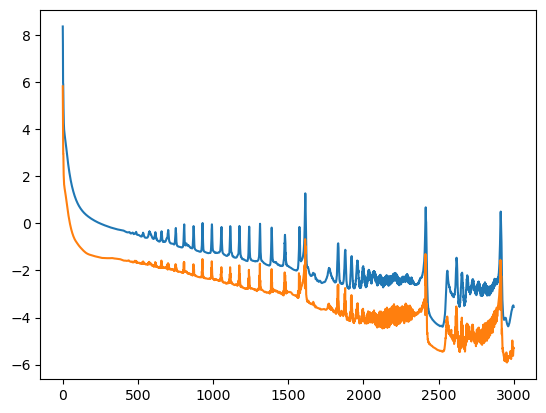

In [276]:
plt.plot(train_log_loss)
plt.plot(validation_log_loss)

In [307]:
# Our imput will have size 80 as it corresponds to 2 relation both of length 20 with each element represented by a two dimensional vector.
# We use a relu activation function. 
class HarderNet(torch.nn.Module):
    def __init__(self):
        super(HarderNet, self).__init__()
        # First hidden layer
        self.hid1 = torch.nn.Linear(80, 200)
        # Second hidden layer
        self.hid2 = torch.nn.Linear(200, 200)
        # Third hidden layer
        self.hid3 = torch.nn.Linear(200, 200)
        # Output layer
        self.outp = torch.nn.Linear(200, 1)
        self.relu = torch.nn.ReLU()
    
    def forward(self, x):
        z = self.relu(self.hid1(x))
        z = self.relu(self.hid2(z))
        z = self.relu(self.hid3(z))
        return self.outp(z)

In [ ]:
# Initialize the model
hard_model = HarderNet()

In [310]:
train_log_loss, validation_log_loss = training_loop_outer(hard_model, train_data, train_reduced_lengths, 0.001, validation_data, validation_reduced_lengths, 1000, 10000)

100%|██████████| 1000/1000 [13:03<00:00,  1.28it/s]


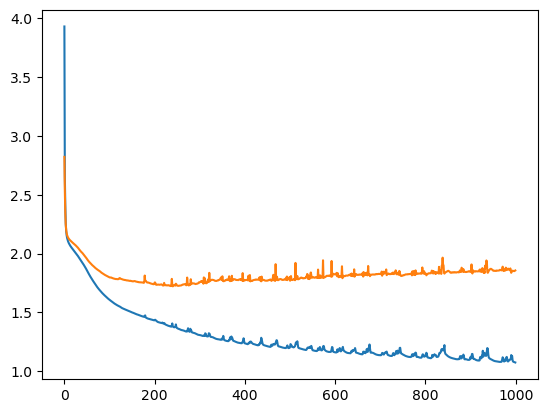

In [311]:
plt.plot(train_log_loss)
plt.plot(validation_log_loss)

In [293]:
train_log_loss[-1]

[np.float64(5.589973397999117)]

In [294]:
validation_log_loss[-1]

np.float64(1.76129340902916)

In [314]:
hard_model(validation_data[:10]).squeeze()

tensor([14.0709, 17.6219,  8.6668, 12.8807,  2.5790, 12.6513, 16.1202, 10.7674,
        10.8689, 10.7052], grad_fn=<SqueezeBackward0>)

In [315]:
validation_reduced_lengths[:10]

tensor([18., 16., 10., 16.,  1., 10., 17., 11., 11., 14.])